# LocImpBranchPro: inference of R_t

The first part of the notebook includes a forward simulation of the local incidence numbers for an example branching process model with both local and imported cases. The reproduction number profile is assumed to be a step function with only one jump. The incidence results are displayed as a barplot.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- explicit calculation;
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd

num_timepoints = 30 # number of days for incidence data

# Build the imported cases
ic_mean = 70
imported_times = np.arange(1,(num_timepoints+1))
imported_cases = scipy.stats.poisson.rvs(ic_mean, size=num_timepoints)

## Parameterize example branching process model with local and imported cases

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

In [3]:
# Construct LocImpBranchProModel object
epsilon = 1

initial_r = 3
serial_interval = disc_w
m = branchpro.LocImpBranchProModel(initial_r, serial_interval, epsilon)

new_rs = [1.5, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

m.set_imported_cases(imported_times, imported_cases)
locally_infected_cases = m.simulate(parameters, times)

print(locally_infected_cases)

[ 100.    0.   41.   76.  130.  170.  245.  281.  340.  440.  503.  594.
  710.  750.  890. 1024.  394.  458.  409.  354.  294.  263.  200.  210.
  174.  172.  151.  121.  121.  117.]


## Plot local incidence numbers and imported cases

In [4]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=locally_infected_cases,
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=imported_cases,
        name='Imported Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Compute the posterior distribution using explicit method

In [5]:
# Posterior of R_t
#epsilon = 0.5

tau = 0
R_t_start = tau+1
a = 1
b = 1/5

shape = []
rate = []
mean = []

# print(len(serial_interval))
# print(len(locally_infected_cases))
# print(len(imported_cases))

i=0
for t in range(R_t_start,num_timepoints):
#     print(t)
    shape.append( a + math.fsum(locally_infected_cases[(t-tau):(t+1)]) )
    sum_var_loc = 0
    sum_var_imp = 0
    for k in range(t-tau,t+1):
        vec1 = locally_infected_cases[(k-1)::-1] # I_loc_(k-1), ... , I_loc_0
        vec2 = imported_cases[(k-1)::-1] # I_imp_(k-1), ... , I_imp_0
        vec3 = serial_interval[:k] # w_1, ... , w_k
        
#         print(len(vec1))
#         print(len(vec2))
#         print(len(vec2))
#         print(np.multiply(vec1,vec3))
#         print(np.multiply(vec2,vec3))
        sum_var_loc += math.fsum( np.multiply(vec1,vec3) )
        sum_var_imp += math.fsum( np.multiply(vec2,vec3) )
    rate.append( 1/b + sum_var_loc + epsilon * sum_var_imp)
    i += 1

# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

mean = np.divide(shape, rate)

post_dist = scipy.stats.gamma(shape, scale = 1/np.array(rate))
post_dist_interval = post_dist.interval(.95)

# print(shape)
# print(rate)
# print(mean)

## Inference plot using explicit calculation results

In [6]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[1.5] + L2*[0.5]
})

interval = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': mean,
    'Lower bound CI': post_dist_interval[0],
    'Upper bound CI': post_dist_interval[1],
    'Central Probability': (L1+L2) * [0.95]
})

In [7]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using pre-computed posterior class method

In [8]:
# Same inference, but using the LocImpBranchProPosterior
epsilon = 1
tau = 0
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': imported_cases
    }
)

inference = branchpro.LocImpBranchProPosterior(
    inc_data=inc_data,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

## Inference plot using class method results

In [9]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using sampling class method

In [10]:
# Same inference, but using the LocImpPoissonBranchProPosterior
epsilon = 1
tau = 0
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': imported_cases
    }
)

inference_new = branchpro.PoissonBranchProLogPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau = tau,
    alpha=a,
    beta=b,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon)


/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/pints/_mcmc/_nuts.py:260: RuntimeWarning:

overflow encountered in exp

/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/pints/_mcmc/_nuts.py:159: RuntimeWarning:

overflow encountered in exp



Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     102    0.65     3       0.5      16      0.686    3        0:00.1
1     105    0.25     2       0.25     1                         0:00.1
2     108                     0.25     1                         0:00.1
3     111                     0.25     1                         0:00.1
20    816    0.732    14      0.778    12      0.7      24       0:00.7
40    1929   0.76     16      0.744    21      0.756    14       0:01.7
60    2877   0.76     14      0.772    16      0.76     11       0:02.5
80    3753   0.747    21      0.736    14      0.743    20       0:03.2
100   4759   0.741    20      0.755    24      0.743269 16       0:04.1
Halting: Maximum number of iterations (100) reached.
Done!
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  --

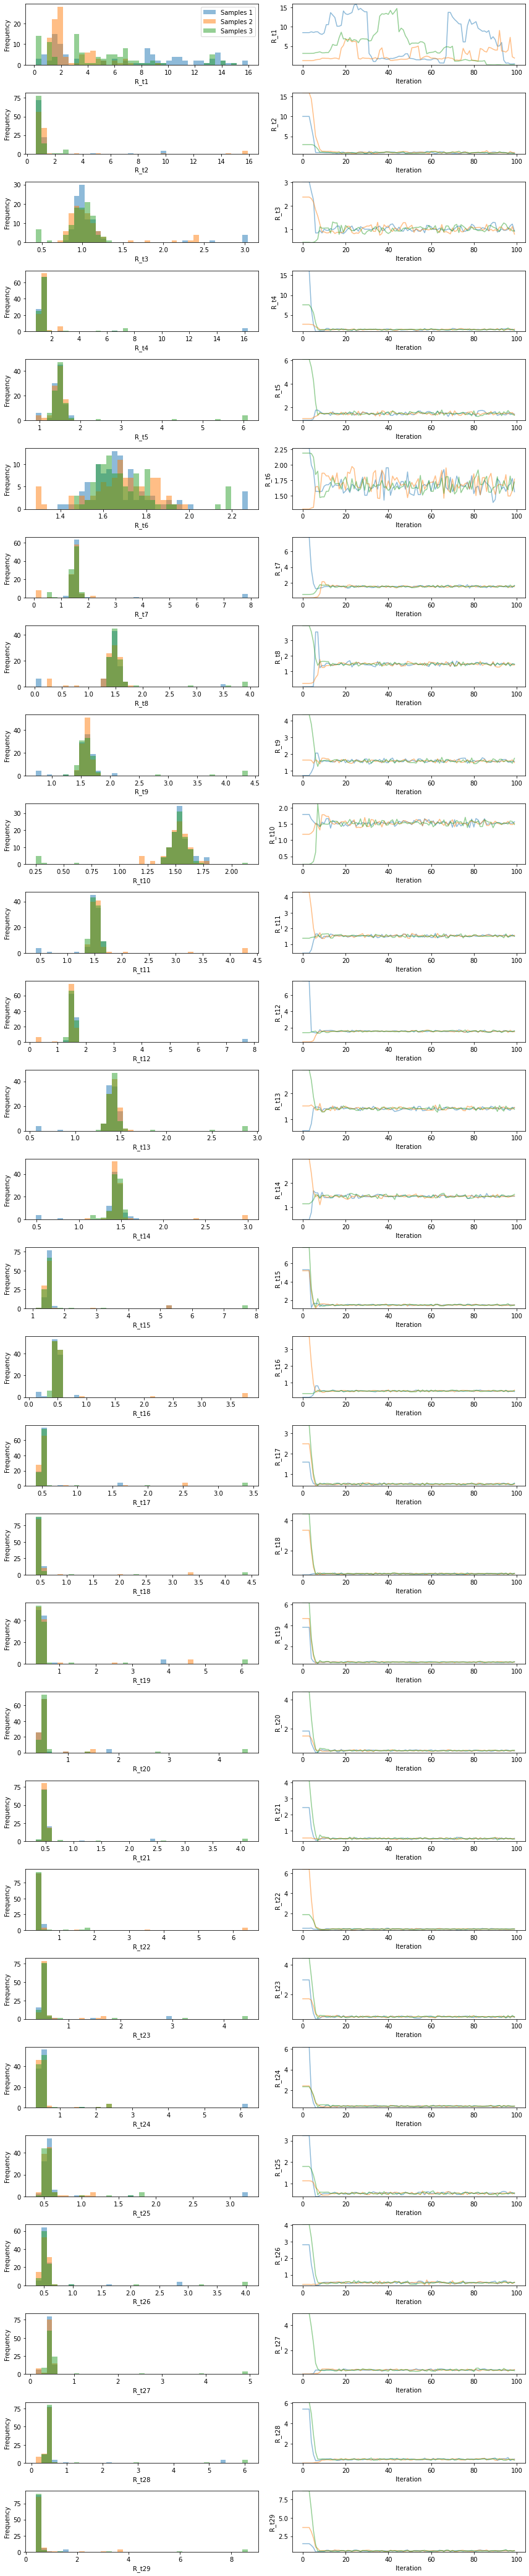

In [11]:
samples = inference_new.run_inference(num_iter=100)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []
for _ in range(inference_new.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_ + R_t_start))

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 50:, :]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 50))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [12]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



In [13]:
dLl = []
old_r_profile = ground_truth['R_t'].to_list()

total_time = inference_new.ll.cases_times.max() - inference_new.ll.cases_times.min() + 1
time_init_inf_r = inference_new.ll._tau + 1

for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
    new_r_profile = old_r_profile.copy()
    new_r_profile[_] = old_r_profile[_] + 10**(-5)
    dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

print(dLl)
print(inference_new.ll._compute_derivative_log_likelihood(old_r_profile))

[0.0, -17.50669689499773, -26.211727163172323, -11.265347438893512, -2.344771655771183, 16.683231297065504, 2.7519955438037864, -3.7593774322886016, 16.418096492998302, 6.754611695214407, 4.6991561248432845, 14.972294775361659, -28.994052809139244, -21.572704190475633, -15.083908874657935, -2.2251077098189853, 15.622156161043675, -17.346107142657274, -3.716682431331719, -21.888117862545183, -7.029824382698279, -70.11038012478821, 6.519351563838426, -9.62808264830528, 25.02448883205943, 12.722285021027345, -23.10141577481772, -5.733559487453021, 8.497998737766466]
[0.0, -17.506605804803254, -26.21155832808467, -11.265058530080267, -2.34439391321591, 16.683775724291763, 2.7526200084438415, -3.75862193946719, 16.41907429221709, 6.755729395758863, 4.700476120392068, 14.973872633940005, -28.99238616822754, -21.57072642375863, -15.08163329875299, -2.217227837182463, 15.63131605779779, -17.337927251126757, -3.7096025346855868, -21.882237951309094, -7.024564449616491, -70.10638019276297, 6.523

In [14]:
theta_hat = inference_new.run_optimisation()[0]
S_vector = np.multiply(np.reciprocal(np.array(shape)-1), np.square(theta_hat))
S = np.diag(S_vector)

q_theta = scipy.stats.multivariate_normal(theta_hat, S)
q_theta1 = scipy.stats.norm(theta_hat, np.sqrt(S_vector))
interval2 = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': q_theta.mean,
    'Lower bound CI': q_theta1.interval(0.95)[0],
    'Upper bound CI': q_theta1.interval(0.95)[1],
    'Central Probability': (L1+L2) * [0.95]
})

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 14
Iter. Eval.  Best      Current   Time m:s
0     14     -3620.758 -3620.758   0:00.0
1     28     -3204.684 -3204.684   0:00.0
2     42     -2376.479 -2376.479   0:00.1
3     56     -2376.479 -2902.899   0:00.1
20    294    -643.1862 -643.1862   0:00.2
40    574    -275.2887 -275.2887   0:00.4
60    854    -199.0821 -223.9599   0:00.5
80    1134   -171.596  -175.9905   0:00.7
100   1414   -164.1371 -165.0738   0:00.9
120   1694   -161.9671 -162.1825   0:01.0
140   1974   -161.1233 -161.1586   0:01.2
160   2254   -160.9338 -160.9369   0:01.4
180   2534   -160.8736 -160.8736   0:01.6
200   2814   -160.8511 -160.8511   0:01.8
220   3094   -160.838  -160.838    0:02.0
222   3108   -160.838  -160.838    0:02.1
Halting: No significant change for 100 iterations.
[2.01426598 0.93857096 0.99854668 1.33791556 1.47485945 1.675903
 1.52839604 1.47786215 1.59325581 1.53614

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_75915/1097880290.py:2: RuntimeWarning:

divide by zero encountered in reciprocal



ValueError: array must not contain infs or NaNs

In [ ]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval2)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



### Compare the two posterior values

In [ ]:
np.sum(inference.inference_posterior.logpdf(old_r_profile)), inference_new.return_logposterior(old_r_profile)

(-224.85555752827577, 50155.097808358885)

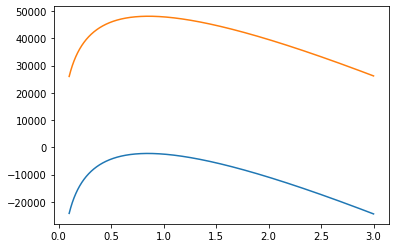

In [ ]:
post1 = []
post2 = []

for i in np.arange(0.1, 3, 0.001):
    var = [i] * len(old_r_profile)
    post1.append(np.sum(inference.inference_posterior.logpdf(var)))
    post2.append(inference_new.return_logposterior(var))

plt.plot(np.arange(0.1, 3, 0.001), post1)
plt.plot(np.arange(0.1, 3, 0.001), post2)